## 2. Entrenamiento y evaluación de modelos

Para este apartado de entrenamiento y evaluación de modelos, necesitamos rescatar el dataframe que resultó luego del análisis exploratorio, el cual está almacenado en un `.pkl`.

In [26]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [2]:
df=pd.read_pickle("data_limpia.pkl")

Ahora, separamos la variable objetivo de las caraterísticas para preparar el dataset para el entrenamiento con los modelos.

In [3]:
X=df.drop(columns=["Churn"])
y=df["Churn"]

Además, codificamos el target:

In [4]:
y = y.map({
    'Yes': 1,
    'No': 0,
})

# Verificamos la codificación
print(y.value_counts())

Churn
0    5174
1    1869
Name: count, dtype: int64


Dividimos nuevamente el dataset, ahora en conjunto de entrenamiento y prueba.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

El conjunto de entrenamiento se dividirá nuevamente en entrenamiento y validación, pero esta división se realizará únicamente en los `pipelines` y el `gridsearching`, esto con el fin de evitar una fuga de datos al evaluar el mejor modelo con los mejores parámetros en un conjunto de prueba que nunca se vió en el entrenamiento.

Además, recordemos que el dataset cuenta con un desbalance del (73.5/26.5), por lo que, para cada modelo, no solo buscaremos los mejores parámetros con `GridSearchCV`, sino que también buscaremos los mejores scores viendo si estos mejoran aplicando un balanceo de clases o no.

Vayamos entonces con los modelos, empezando con `Random Forest`.

### 2.1 Random Forest

Para el modelo `Random Forest`, y en general para todos los modelos, decidimos integrar en un solo pipeline tanto la búsqueda de los mejores hiperparámetros, como la búsqueda de si es necesario el balanceo o no, es decir, si con un balanceo de clases los scores mejoran o no.

En este caso los balanceos que estaremos aplicando serán por el parámetro `class_weight='balanced'`, y por `SMOTE`.

Además, ajustaremos los parámetros recomendados en el enunciado de la actividad, junto con los clásicos `n_estimators` y `max_depth

In [86]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as Pipeline 
from imblearn.over_sampling import SMOTE

# Identificamos las columnas categóricas para la codificación necesaria en Random Forest
cat_cols = []
for col in X.columns:
    if X[col].dtype == "object":
        cat_cols.append(col)
        
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ], remainder="passthrough" # las columnas numéricas se mantienen sin cambios
)

# Definimos el pipeline de Random Forest
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("sampler", "passthrough"),
    ("rf", RandomForestClassifier(random_state=42))
])

# Param grid para el grid search que incluye opciones de balanceo e hiperparámetros del modelo

param_grid = [
    # Sin balanceo
    {
        "sampler": ["passthrough"],
        "rf__class_weight": [None],
        "rf__n_estimators": [100, 200],
        "rf__max_depth": [None, 10, 20],
        "rf__min_samples_split": [2, 5],
        "rf__min_samples_leaf": [1, 2],
        "rf__max_features": ["sqrt", "log2"],
        "rf__bootstrap": [True, False],
        "rf__criterion": ["gini", "entropy"]
    },

    # Balanceo interno (class_weight)
    {
        "sampler": ["passthrough"],
        "rf__class_weight": ["balanced"],
        "rf__n_estimators": [100, 200],
        "rf__max_depth": [None, 10, 20],
        "rf__min_samples_split": [2, 5],
        "rf__min_samples_leaf": [1, 2],
        "rf__max_features": ["sqrt", "log2"],
        "rf__bootstrap": [True, False],
        "rf__criterion": ["gini", "entropy"]
    },

    # Balanceo externo (SMOTE)
    {
        "sampler": [SMOTE(random_state=42)],
        "rf__class_weight": [None],
        "rf__n_estimators": [100, 200],
        "rf__max_depth": [None, 10, 20],
        "rf__min_samples_split": [2, 5],
        "rf__min_samples_leaf": [1, 2],
        "rf__max_features": ["sqrt", "log2"],
        "rf__bootstrap": [True, False],
        "rf__criterion": ["gini", "entropy"]
    }
]

Veamos ahora los mejores parámetros utilizando la métrica `roc_auc` para escoger los mismos. Decidimos escoger esta métrica ya que nos interesa que el modelo sepa asignarle una probabilidad mayor a los registros de la clase positiva que a los de la clase negativa.

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
kfold=StratifiedKFold(n_splits=5)
grid_search_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=kfold,
    n_jobs=-1, # se usan todos los núcleos disponibles
    verbose=2
)

grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',...
                          'rf__n_estimators': [100, 200],
                          'sampler': ['passthrough']},
                         {'rf__bootstrap': [True, False],
                          'rf__class_weight': [None],
                          'rf__criterion': ['gini', 'entropy'],
                          'rf__max_depth': [None, 10, 20],
                          'rf__max_features': ['sqrt', 'log2'],
                          'rf__min_samples_leaf': [1, 2],
                          'rf__min_samples_split': [2, 5],
                          'rf__n_estimators': [100, 200],
                          'sampler': [SMOTE(random_state=42)]}],
             scoring='roc_auc', verbose=2)

In [56]:
print("Best parameter: {}".format(grid_search_rf.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search_rf.best_score_))

Best parameter: {'rf__bootstrap': True, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 200, 'sampler': 'passthrough'}
Best cross-validation score: 0.85


Luego de la búsqueda de los mejores parámetros, obtuvimos un resultado bastante decente de la métrica `roc_auc`. Veamos ahora el modelo entrenado con el conjunto de entrenamiento original y evaluado con el conjunto de test que se reservó exclusivamente para la evaluación.

In [57]:
from sklearn.metrics import classification_report
best_model_rf = grid_search_rf.best_estimator_

# Reentrenar con el X_train completo
best_model_rf.fit(X_train, y_train)

# Evaluar en el test reservado
y_pred = best_model_rf.predict(X_test)
y_proba = best_model_rf.predict_proba(X_test)[:, 1]
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['No churn', 'Churn']))



 Reporte de clasificación:
              precision    recall  f1-score   support

    No churn       0.89      0.79      0.84      1294
       Churn       0.56      0.74      0.63       467

    accuracy                           0.77      1761
   macro avg       0.72      0.76      0.74      1761
weighted avg       0.80      0.77      0.78      1761



De este reporte obtenemos lo siguiente:

- Clase `No churn`: Para la clase negativa se obtuvieron buenos resultados, un precision de `0.89` que indica que el 89% de las predicciones para esta clase fueron correctas, mientras que el `recall` baja a 0.79 y el `f1-score` se mantiene en 0.84.

- Clase `Churn`: El comportamiento de las predicciones que vimos en al análisis de la clase `No churn` se complementa con este análisis, al obtener un `precision` 0.56 y un `recall` de 0.74, vemos que, si bien predice correctamente buena parte de los **positivos reales**, a su vez clasifica muchos falsos positivos.

- Por último, se obtuvo un `accuracy` de 0.77.

Pasemos con la matriz de confusión:

[[1019  275]
 [ 122  345]]


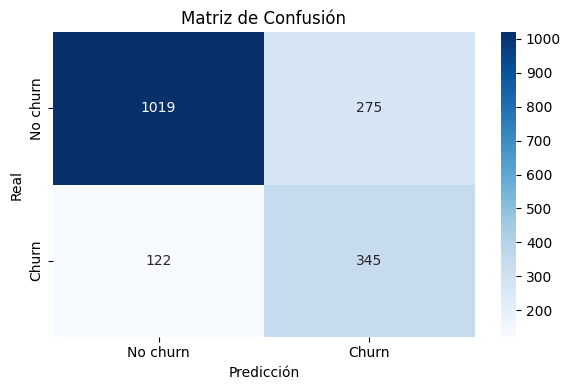

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

print(cm)
# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['No churn', 'Churn'],
            yticklabels=['No churn', 'Churn'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión")
plt.tight_layout()
plt.show()

Los resultados de la matriz de confusión confirman lo que se mencionó en el reporte de clasificación, el modelo tuvo un mejor rendimiento para predecir la clase negativa que la clase positiva, pero clasifica correctamente una buena parte de los positivos reales.

Veamos la curva `ROC` y el valor `AUC`:

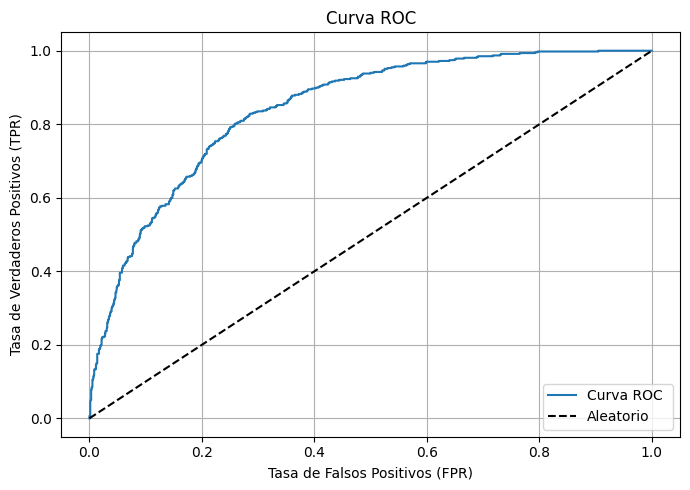

AUC (Área bajo la curva ROC): 0.8429


In [59]:
from sklearn.metrics import roc_curve, roc_auc_score
# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# Calcular AUC
auc_score = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Curva ROC ')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC (Área bajo la curva ROC): {auc_score:.4f}")

Tanto la curva `ROC` como el `AUC` nos informan que el modelo random forest tiene una buena capacidad para asignar una probabilidad mayor a la clase positiva que a la clase negativa.

Antes de pasar al siguiente modelo, veamos las `feature importances` de este:

                           feature  importance
43                          tenure    0.128006
45                    TotalCharges    0.114578
34         Contract_Month-to-month    0.097905
44                  MonthlyCharges    0.082801
36               Contract_Two year    0.060251
14     InternetService_Fiber optic    0.039284
25                  TechSupport_No    0.039268
16               OnlineSecurity_No    0.038913
41  PaymentMethod_Electronic check    0.031513
35               Contract_One year    0.019403


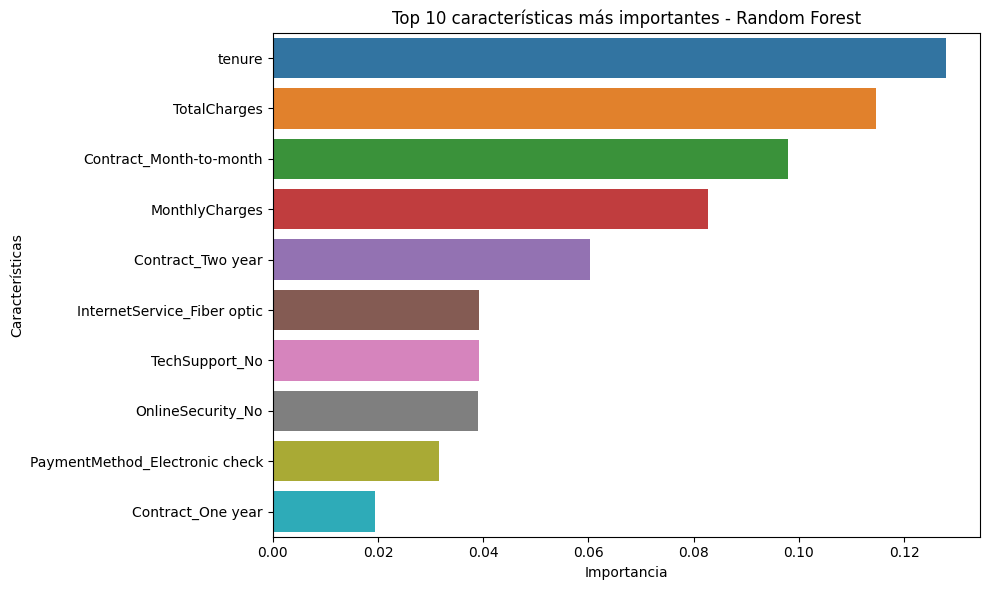

In [60]:
# Extraer el paso del modelo Random Forest
rf_model = best_model_rf.named_steps["rf"]

#Extraer el preprocesador
preprocessor = best_model_rf.named_steps["preprocessor"]

# Obtener los nombres de las columnas codificadas con OneHotEncoder
ohe = preprocessor.named_transformers_["cat"]
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)

# Detectamos cuáles columnas no fueron categóricas
num_cols = [c for c in X.columns if c not in cat_cols]

# Concatenamos nombres codificados + numéricos
feature_names = list(encoded_cat_cols) + num_cols

# Obtenemos importancias del modelo
importances = rf_model.feature_importances_

# Creamos DataFrame con nombres y valores
feat_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Las 10 características más importantes
print(feat_importances.head(10))

# Graficamos las 10 características más importantes
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feat_importances.head(10))
plt.title("Top 10 características más importantes - Random Forest")
plt.xlabel("Importancia")   
plt.ylabel("Características")
plt.tight_layout()
plt.show()


Con este gráfico podemos observar cuales fueron las **características que mejor separaron el target** al momento de construir los árboles del bosque aleatorio, siendo `tenure` en este caso la más "importante" en este ámbito, mientras que otras características como `TotalCharges`, `Contract_Month-to-month` y ` MonthlyCharges` también fueron importantes para la división del target en los árboles, pero con menos peso que `tenure`.

Pasemos ahora con el modelo `XGBoost`:

### 2.2 XGBoost

Este modelo no tiene el parámetro `class_weight='balanced'`, por lo que solo realizamos el modelo sin balanceo, y el balanceo por `SMOTE`.

Así mismo, a partir de ahora decidimos reducir el número de hiperparámetros ajustados, debido a que resultaba en un proceso muy costoso computacionalmente, y los scores cambiaban muy poco con respecto a los scores dados por una búsqueda más sencilla, así que decidimos no ajustar tantos hiperparámetros al mismo tiempo, ya que la mejora era muy baja.

Los hiperparámetros que estaremos evaluando serán los correspondientes al número de árboles usados (`n_estimators`), a la profundidad máxima de los mismos (`max_depth`) y al grado en que cada árbol controla los errores de los árboles anteriores (`learning_rate`).

Además, se utilizará la GPU para el entrenamiento de los modelos que faltan, ya que cuentan con soporte para esta labor.

In [ ]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as Pipeline
from xgboost import XGBClassifier
import pandas as pd


preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ], remainder="passthrough" # las columnas numéricas se mantienen sin cambios
)

xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("sampler", "passthrough"),
    ("xgb", XGBClassifier(
        random_state=42,
        tree_method='gpu_hist',  # Entrenamiento con GPU
        eval_metric='logloss'    
    ))
])

# Definimos el param grid para XGBoost
param_grid = [
    # Sin balanceo
    {
        "sampler": ["passthrough"],
        "xgb__n_estimators": [100, 200],
        "xgb__max_depth": [3, 6, 10],
        "xgb__learning_rate": [0.01, 0.1, 0.3],
    },

    # Balanceo externo con SMOTE
    {
        "sampler": [SMOTE(random_state=42)],
        "xgb__n_estimators": [100, 200],
        "xgb__max_depth": [3, 6, 10],
        "xgb__learning_rate": [0.01, 0.1, 0.3]
    }
]


In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
kfold=StratifiedKFold(n_splits=5)
grid_search_xgb = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=kfold,
    n_jobs=-1,
    verbose=2
)

grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',...
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid=[{'sampler': ['passthrough'],
                          'xgb__learning_rate': [0.01, 0.1, 0.3],
                          'xgb__max_depth': [3, 6, 10],
                          'xgb__n_estimators': [100, 200]},
                         {'sampler': [SMOTE(random_state=42)],
                          'xgb__learning_rate': [0.01, 0.1, 0.3],
                          'xgb__max_depth': [3, 6, 10],
                          'xgb__n_estimators': [100, 200]}],
             scoring='roc_auc', verbose=2)

In [69]:
print("Best parameter: {}".format(grid_search_xgb.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search_xgb.best_score_))

Best parameter: {'sampler': 'passthrough', 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}
Best cross-validation score: 0.85


Nuevamente obtuvimos un `roc_auc` de 0.85, veamos ahora el modelo con los mejores parámetros conseguidos:

In [70]:
from sklearn.metrics import classification_report
best_model_xgb = grid_search_xgb.best_estimator_

# Reentrenar con el X_train completo
best_model_xgb.fit(X_train, y_train)

# Evaluar en el test reservado
y_pred = best_model_xgb.predict(X_test)
y_proba = best_model_xgb.predict_proba(X_test)[:, 1]
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['No churn', 'Churn']))



 Reporte de clasificación:
              precision    recall  f1-score   support

    No churn       0.83      0.91      0.87      1294
       Churn       0.66      0.50      0.57       467

    accuracy                           0.80      1761
   macro avg       0.75      0.70      0.72      1761
weighted avg       0.79      0.80      0.79      1761



A diferencia del modelo anterior, en este se obtuvo una mejora en la clasificación de la clase `No churn`, con un `precision` de 0.83 y un `recall` de 0.91, es decir, se capturaron mejor los negativos reales y se mejoró la precisión del modelo al clasificar los negativos. Sin embargo, el rendimiento de la clase positiva cambió, la proporción de positivos clasificados correctamente mejoró, pero en total solo capturó la mitad de los positivos reales, así que en ese sentido este modelo es peor clasificando la clase positiva, pero mejor con la clase negativa.

[[1175  119]
 [ 235  232]]


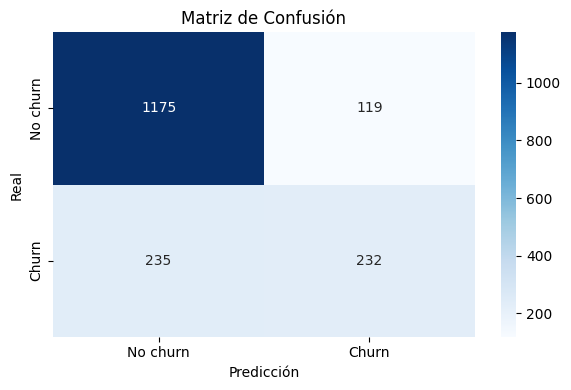

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

print(cm)
# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['No churn', 'Churn'],
            yticklabels=['No churn', 'Churn'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión")
plt.tight_layout()
plt.show()

Lo dicho en el análisis del reporte de clasificación se confirma en la matriz de confusión, el modelo mejoró la clasificación de la clase negativa con respecto al random forest, pero empeoró en la clasificación de la clase positiva.

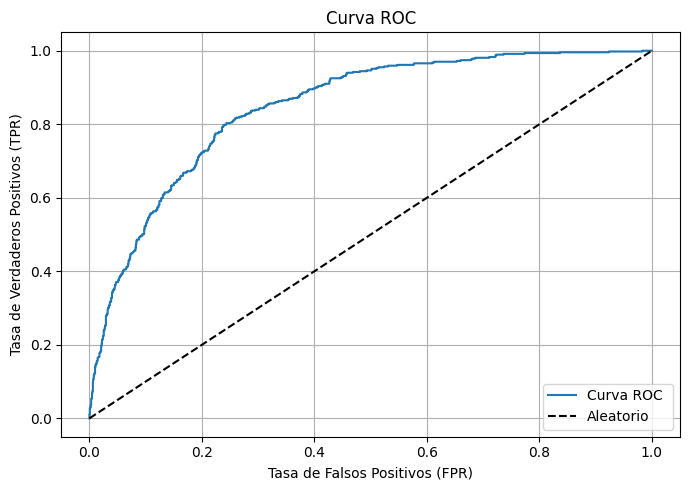

AUC (Área bajo la curva ROC): 0.8469


In [72]:
from sklearn.metrics import roc_curve, roc_auc_score
# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# Calcular AUC
auc_score = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Curva ROC ')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC (Área bajo la curva ROC): {auc_score:.4f}")

Sin embargo la curva `ROC` y el valor `AUC` se mantuvieron similares a las del anterior modelo.

                           feature  importance
34         Contract_Month-to-month    0.515885
14     InternetService_Fiber optic    0.131057
25                  TechSupport_No    0.078700
16               OnlineSecurity_No    0.042289
41  PaymentMethod_Electronic check    0.023923
43                          tenure    0.023729
33             StreamingMovies_Yes    0.018206
15              InternetService_No    0.018205
19                 OnlineBackup_No    0.013882
36               Contract_Two year    0.013379


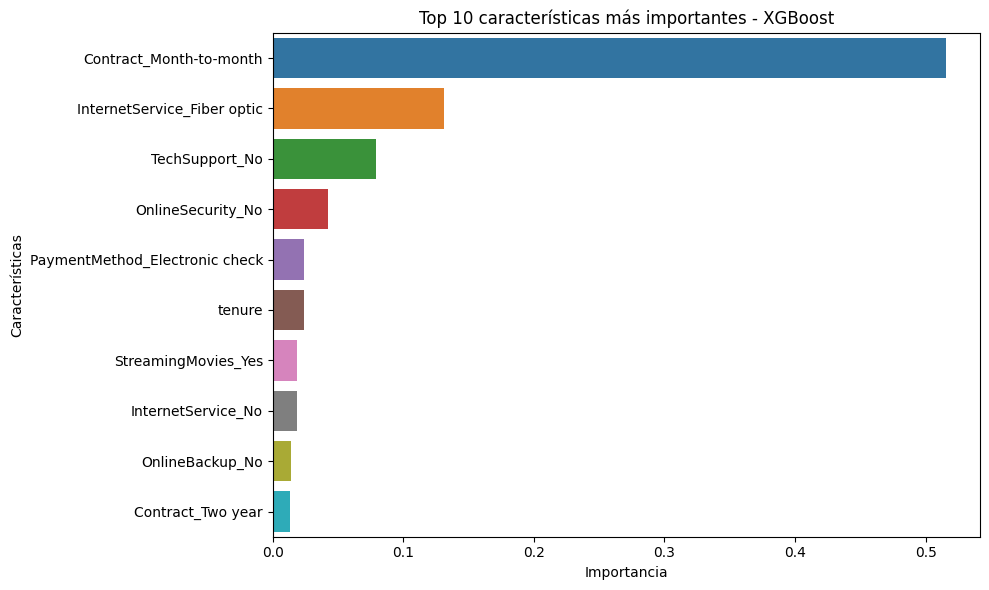

In [73]:
# Extraer el paso del modelo Random Forest
xgb_model = best_model_xgb.named_steps["xgb"]

#Extraer el preprocesador
preprocessor = best_model_xgb.named_steps["preprocessor"]

# Obtener los nombres de las columnas codificadas con OneHotEncoder
ohe = preprocessor.named_transformers_["cat"]
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)

# Detectamos cuáles columnas no fueron categóricas
num_cols = [c for c in X.columns if c not in cat_cols]

# Concatenamos nombres codificados + numéricos
feature_names = list(encoded_cat_cols) + num_cols

# Obtenemos importancias del modelo
importances = xgb_model.feature_importances_

# Creamos DataFrame con nombres y valores
feat_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Las 10 características más importantes
print(feat_importances.head(10))

# Graficamos las 10 características más importantes
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feat_importances.head(10))
plt.title("Top 10 características más importantes - XGBoost")
plt.xlabel("Importancia")   
plt.ylabel("Características")
plt.tight_layout()
plt.show()


A diferencia del modelo anterior, en este hubo una característica que tuvo más peso que las demás a la hora de dividir al target, que en este caso, al haber codificado las categorías, es la categoría `Month-to-Month` de la variable `Contract` que indica el término del contrato del cliente, mientras que otras características como `InternetService_Fiber optic` y ` TechSupport_No ` también fueron importantes para la construcción de los árboles.

### 2.3 CatBoost

Este modelo tampoco cuenta con el parámetro `class_weight='balanced'`, por lo que solo se realizará el balanceo con SMOTE.

Además, se hará uso de la GPU para el entrenamiento y se buscarán los mejores hiperparámetros similares a los de XGBoost:  el número de árboles usados (`iterations`), la profundidad máxima de los mismos (`depth`), el grado en que cada árbol controla los errores de los árboles anteriores (`learning_rate`) y consideramos ajustar un coeficiente de regularización L2 (`l2_leaf_reg`).

In [7]:
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ], remainder="passthrough" # las columnas numéricas se mantienen sin cambios
)


# Creamos el pipeline base
cat_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("sampler", "passthrough"),  
    ("cat", CatBoostClassifier(
        random_state=42,
        task_type="GPU"        
    ))
])

param_grid = [
    # Sin balanceo (normal)
    {
        "sampler": ["passthrough"],
        "cat__iterations": [200, 400],
        "cat__learning_rate": [0.05, 0.1],
        "cat__depth": [4, 6, 8],
        "cat__l2_leaf_reg": [1, 3, 5],
    },

    # Con SMOTE
    {
        "sampler": [SMOTE(random_state=42)],
        "cat__iterations": [200, 400],
        "cat__learning_rate": [0.05, 0.1],
        "cat__depth": [4, 6, 8],
        "cat__l2_leaf_reg": [1, 3, 5],
    }
]

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
kfold=StratifiedKFold(n_splits=5)
grid_search_cat = GridSearchCV(
    estimator=cat_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=kfold,
    n_jobs=1,
    verbose=2
)

grid_search_cat.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
0:	learn: 0.6601560	total: 23.5ms	remaining: 4.68s
1:	learn: 0.6288027	total: 28.2ms	remaining: 2.79s
2:	learn: 0.6029304	total: 31.5ms	remaining: 2.07s
3:	learn: 0.5806519	total: 34.4ms	remaining: 1.69s
4:	learn: 0.5609154	total: 37.3ms	remaining: 1.45s
5:	learn: 0.5450023	total: 40.5ms	remaining: 1.31s
6:	learn: 0.5300896	total: 42.9ms	remaining: 1.18s
7:	learn: 0.5186662	total: 56.5ms	remaining: 1.35s
8:	learn: 0.5083454	total: 59.3ms	remaining: 1.26s
9:	learn: 0.4988836	total: 63.6ms	remaining: 1.21s
10:	learn: 0.4901566	total: 67.8ms	remaining: 1.17s
11:	learn: 0.4825774	total: 70.2ms	remaining: 1.1s
12:	learn: 0.4760460	total: 73.9ms	remaining: 1.06s
13:	learn: 0.4704913	total: 78.2ms	remaining: 1.04s
14:	learn: 0.4641670	total: 80.7ms	remaining: 995ms
15:	learn: 0.4596139	total: 84.5ms	remaining: 972ms
16:	learn: 0.4544126	total: 88ms	remaining: 948ms
17:	learn: 0.4506196	total: 91ms	remaining: 920ms
18:	learn: 0.4466

  File "c:\Users\Hector\miniconda3\envs\ml_venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Hector\miniconda3\envs\ml_venv\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Hector\miniconda3\envs\ml_venv\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Hector\miniconda3\envs\ml_venv\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


0:	learn: 0.6537535	total: 13.8ms	remaining: 2.75s
1:	learn: 0.6268828	total: 17.9ms	remaining: 1.77s
2:	learn: 0.5954024	total: 21.5ms	remaining: 1.41s
3:	learn: 0.5749595	total: 25.2ms	remaining: 1.23s
4:	learn: 0.5434538	total: 29ms	remaining: 1.13s
5:	learn: 0.5281016	total: 32.8ms	remaining: 1.06s
6:	learn: 0.5092359	total: 36.4ms	remaining: 1s
7:	learn: 0.4972599	total: 40.2ms	remaining: 966ms
8:	learn: 0.4801645	total: 43.8ms	remaining: 930ms
9:	learn: 0.4695851	total: 48.8ms	remaining: 927ms
10:	learn: 0.4578939	total: 52.9ms	remaining: 909ms
11:	learn: 0.4447521	total: 56.8ms	remaining: 889ms
12:	learn: 0.4319788	total: 60.4ms	remaining: 869ms
13:	learn: 0.4255956	total: 64.2ms	remaining: 853ms
14:	learn: 0.4131263	total: 67.9ms	remaining: 837ms
15:	learn: 0.4044551	total: 71.7ms	remaining: 825ms
16:	learn: 0.3963882	total: 75.6ms	remaining: 814ms
17:	learn: 0.3891586	total: 79.3ms	remaining: 802ms
18:	learn: 0.3854199	total: 83.6ms	remaining: 796ms
19:	learn: 0.3782500	total:

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',...
                                        <catboost.core.CatBoostClassifier object at 0x000002482A305670>)]),
             n_jobs=1,
             param_grid=[{'cat__depth': [4, 6, 8],
                          'cat__iterations': [200, 400],
                          'cat__l2_leaf_reg': [1, 3, 5],
                          'cat__learning_rate': [0.05, 0.1],
                          'sampler': ['passthrough']},
                         {'cat__depth': [4, 6, 8],
                          'cat__iterations': [200, 400],
                          'cat__l2_leaf_reg': [1, 3, 5],
                          'cat__learning_rate': [0.05, 0.1],
                          'sampler': [SMOTE(random_state=42)]}],
             scoring='roc_auc', verbose=2)

In [10]:
print("Best parameter: {}".format(grid_search_cat.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search_cat.best_score_))

Best parameter: {'cat__depth': 4, 'cat__iterations': 200, 'cat__l2_leaf_reg': 5, 'cat__learning_rate': 0.05, 'sampler': 'passthrough'}
Best cross-validation score: 0.85


In [12]:
from sklearn.metrics import classification_report
best_model_cat = grid_search_cat.best_estimator_

# Reentrenar con el X_train completo
best_model_cat.fit(X_train, y_train)


0:	learn: 0.6611339	total: 4.11ms	remaining: 817ms
1:	learn: 0.6326063	total: 6.8ms	remaining: 673ms
2:	learn: 0.6066676	total: 9.74ms	remaining: 640ms
3:	learn: 0.5839644	total: 12.3ms	remaining: 604ms
4:	learn: 0.5652701	total: 15ms	remaining: 584ms
5:	learn: 0.5488672	total: 18.3ms	remaining: 592ms
6:	learn: 0.5336337	total: 20.7ms	remaining: 572ms
7:	learn: 0.5229175	total: 23.6ms	remaining: 566ms
8:	learn: 0.5115611	total: 26.1ms	remaining: 553ms
9:	learn: 0.5007718	total: 28.6ms	remaining: 543ms
10:	learn: 0.4936989	total: 32.1ms	remaining: 551ms
11:	learn: 0.4859541	total: 35ms	remaining: 548ms
12:	learn: 0.4791854	total: 38.6ms	remaining: 555ms
13:	learn: 0.4724755	total: 41.2ms	remaining: 548ms
14:	learn: 0.4676436	total: 44.7ms	remaining: 552ms
15:	learn: 0.4629147	total: 47.2ms	remaining: 543ms
16:	learn: 0.4581746	total: 50.9ms	remaining: 547ms
17:	learn: 0.4539667	total: 53.4ms	remaining: 540ms
18:	learn: 0.4500275	total: 55.9ms	remaining: 532ms
19:	learn: 0.4466132	total:

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('sampler', 'passthrough'),
                ('cat',
                 <catboost.core.CatBoostClassifier object at 0x000002482AC26F10>)])

In [13]:

# Evaluar en el test reservado
y_pred = best_model_cat.predict(X_test)
y_proba = best_model_cat.predict_proba(X_test)[:, 1]
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['No churn', 'Churn']))



 Reporte de clasificación:
              precision    recall  f1-score   support

    No churn       0.84      0.91      0.87      1294
       Churn       0.67      0.51      0.58       467

    accuracy                           0.80      1761
   macro avg       0.75      0.71      0.72      1761
weighted avg       0.79      0.80      0.79      1761



En este reporte de clasificación obtuvimos resultados muy similares a los del modelo XGBoost: se clasifica mejor a la clase negativa mientras se empeorá el rendimiento de clasificación de la clase positiva.

[[1178  116]
 [ 231  236]]


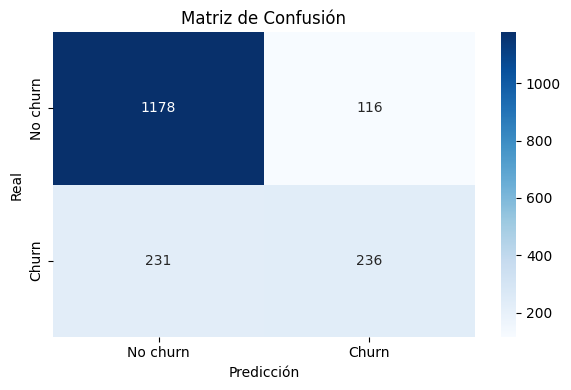

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

print(cm)
# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['No churn', 'Churn'],
            yticklabels=['No churn', 'Churn'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión")
plt.tight_layout()
plt.show()

Incluso las predicciones, que podemos ver su comportamiento gracias a la matriz de confusión, son muy similares al del anterior modelo.

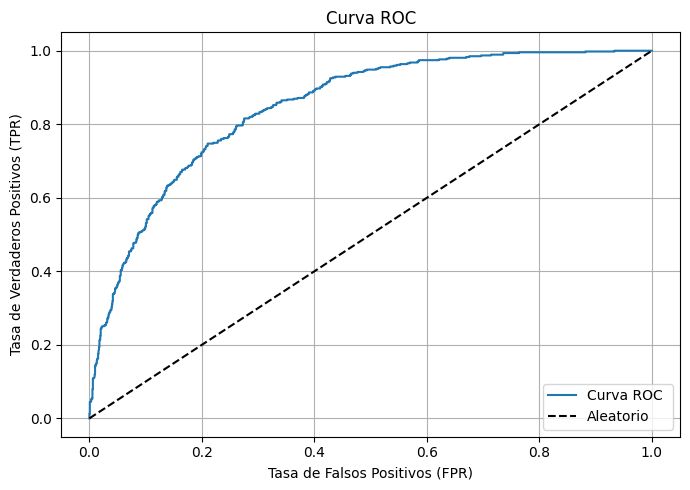

AUC (Área bajo la curva ROC): 0.8475


In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# Calcular AUC
auc_score = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Curva ROC ')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC (Área bajo la curva ROC): {auc_score:.4f}")

Para la curva `ROC` y el `AUC`, nuevamente vemos que este modelo tiene una buena capacidad a la hora de asignar una mayor probabilidad a los elementos de la clase positiva, que a los de la clase negativa.

                           feature  importance
43                          tenure    0.177846
34         Contract_Month-to-month    0.138321
45                    TotalCharges    0.106867
44                  MonthlyCharges    0.100402
14     InternetService_Fiber optic    0.099678
36               Contract_Two year    0.067776
16               OnlineSecurity_No    0.052736
25                  TechSupport_No    0.038029
41  PaymentMethod_Electronic check    0.025290
38            PaperlessBilling_Yes    0.018351


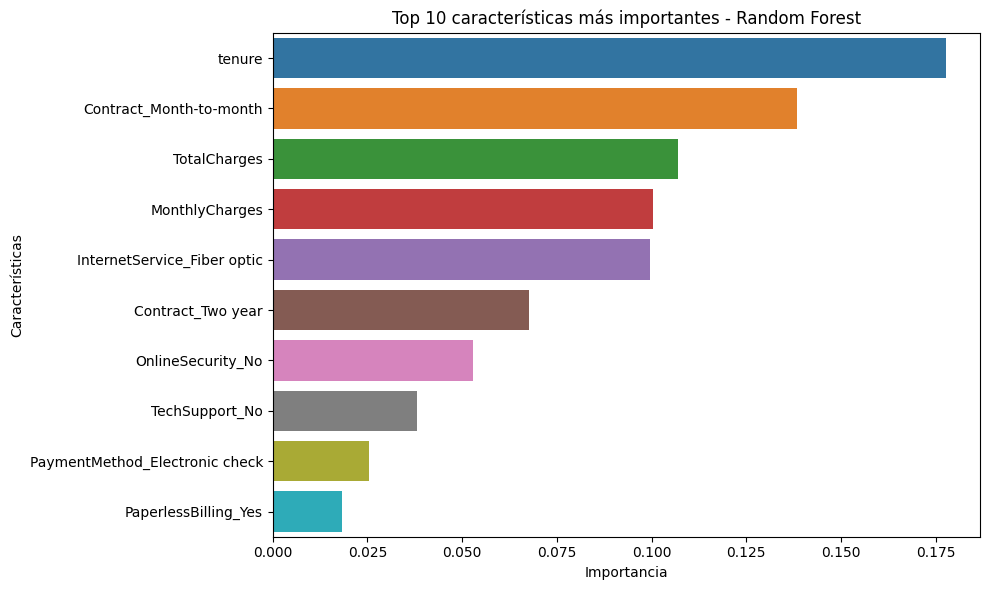

In [19]:
# Extraer el paso del modelo Random Forest
cat_model = best_model_cat.named_steps["cat"]

#Extraer el preprocesador
preprocessor = best_model_cat.named_steps["preprocessor"]

# Obtener los nombres de las columnas codificadas con OneHotEncoder
ohe = preprocessor.named_transformers_["cat"]
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)

# Detectamos cuáles columnas no fueron categóricas
num_cols = [c for c in X.columns if c not in cat_cols]

# Concatenamos nombres codificados + numéricos
feature_names = list(encoded_cat_cols) + num_cols

# Obtenemos importancias del modelo
importances = cat_model.feature_importances_
importances = importances / importances.sum()  # Normalización de las importances

# Creamos DataFrame con nombres y valores
feat_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Las 10 características más importantes
print(feat_importances.head(10))

# Graficamos las 10 características más importantes
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feat_importances.head(10))
plt.title("Top 10 características más importantes - Random Forest")
plt.xlabel("Importancia")   
plt.ylabel("Características")
plt.tight_layout()
plt.show()


Por último, lo que si cambió con respecto al modelo XGBoost fueron las características más importantes a la hora de dividir el target, la cual ahora es `tenure` seguido de `Contract_Month-to-month`, `TotalCharges` y `MonthlyCharges`.

### 2.4 LightGBM

Para el modelo `LightGBM`, nuevamente se hará la búsqueda de los mejores hiperparámetros más comunes, incluyendo el parámetro `num_leaves` que controla el máximo de hojas de los árboles. Además, este modelo lo cuenta con el parámetro `class_weight='balanced'` por lo que solo buscaremos si el balanceo con `SMOTE` es mejor que el modelo sin balanceo.

El entrenamiento se realizá nuevamente con la gpu.

In [74]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ], remainder="passthrough" # las columnas numéricas se mantienen sin cambios
)
# Pipeline (LightGBM maneja las categóricas directamente)
lgbm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("sampler", "passthrough"),
    ("lgbm", LGBMClassifier(
        random_state=42,
        device='gpu',
        gpu_platform_id=1,
        gpu_device_id=1,    
        boosting_type='gbdt',
    ))
])

# Definimos el grid: incluye versiones con y sin balanceo
param_grid = [
    {
        "sampler": ["passthrough"],
        "lgbm__n_estimators": [100, 200],
        "lgbm__learning_rate": [0.05, 0.1],
        "lgbm__max_depth": [-1, 10, 20],
        "lgbm__num_leaves": [30, 60]
    },
    # Balanceo externo con SMOTE
    
    {
        "sampler": [SMOTE(random_state=42)],
        "lgbm__n_estimators": [100, 200],
        "lgbm__learning_rate": [0.05, 0.1],
        "lgbm__max_depth": [-1, 10, 20],
        "lgbm__num_leaves": [30, 60]
    }
] 

In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
kfold=StratifiedKFold(n_splits=5)
grid_search_lgbm = GridSearchCV(
    estimator=lgbm_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=kfold,
    n_jobs=-1,
    verbose=2
)

grid_search_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Info] Number of positive: 3880, number of negative: 3880
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 9097
[LightGBM] [Info] Number of data points in the train set: 7760, number of used features: 46
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 21 dense feature groups (0.18 MB) transferred to GPU in 0.002760 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',...
             n_jobs=-1,
             param_grid=[{'lgbm__learning_rate': [0.05, 0.1],
                          'lgbm__max_depth': [-1, 10, 20],
                          'lgbm__n_estimators': [100, 200],
                          'lgbm__num_leaves': [30, 60],
                          'sampler': ['passthrough']},
                         {'lgbm__learning_rate': [0.05, 0.1],
                          'lgbm__max_depth': [-1, 10, 20],
                          'lgbm__n_estimators': [100, 200],
                          'lgbm__num_leaves': [30, 60],
                          'sampler': [SMOTE(random_state=42)]}],
             scoring='roc_auc', verbose=2)

In [76]:
print("Best parameter: {}".format(grid_search_lgbm.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search_lgbm.best_score_))

Best parameter: {'lgbm__learning_rate': 0.05, 'lgbm__max_depth': -1, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 30, 'sampler': SMOTE(random_state=42)}
Best cross-validation score: 0.84


In [77]:
from sklearn.metrics import classification_report
best_model_lgbm = grid_search_lgbm.best_estimator_

# Reentrenar con el X_train completo
best_model_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 3880, number of negative: 3880
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 9097
[LightGBM] [Info] Number of data points in the train set: 7760, number of used features: 46
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 21 dense feature groups (0.18 MB) transferred to GPU in 0.001901 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('sampler', SMOTE(random_state=42)),
                ('lgbm',
                 LGBMClassifier(device='gpu', gpu_device_id=1,
                                gpu_platform_id=1, learning_rate=0.05,
                                num_leaves=30, random_state=42))])

In [78]:
# Evaluar en el test reservado
y_pred = best_model_lgbm.predict(X_test)
y_proba = best_model_lgbm.predict_proba(X_test)[:, 1]
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['No churn', 'Churn']))


 Reporte de clasificación:
              precision    recall  f1-score   support

    No churn       0.84      0.88      0.86      1294
       Churn       0.63      0.54      0.58       467

    accuracy                           0.79      1761
   macro avg       0.73      0.71      0.72      1761
weighted avg       0.78      0.79      0.79      1761



Los resultados de este reporte de clasificación nos indican que el modelo tiene una buena capacidad para clasificar la clase negativa, pero un bajo rendimiento para la clase positiva, como pasó en los dos modelos anteriores.

[[1144  150]
 [ 216  251]]


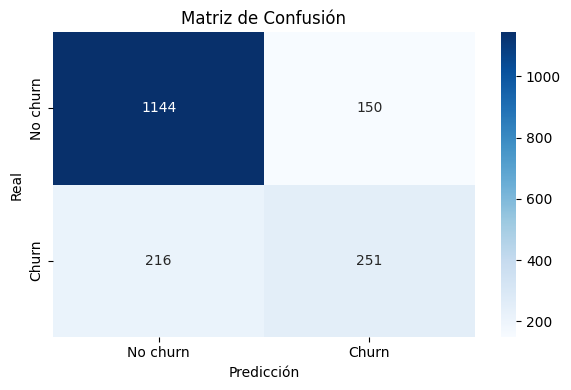

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

print(cm)
# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  
            xticklabels=['No churn', 'Churn'],
            yticklabels=['No churn', 'Churn'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión")
plt.tight_layout()
plt.show()

Como ya vimos en el análisis del reporte de clasificación, el modelo genera mejores predicciones para la clase negativa que para la clase positiva, una tendencia que se ha mantenido en los últimos 3 modelos.

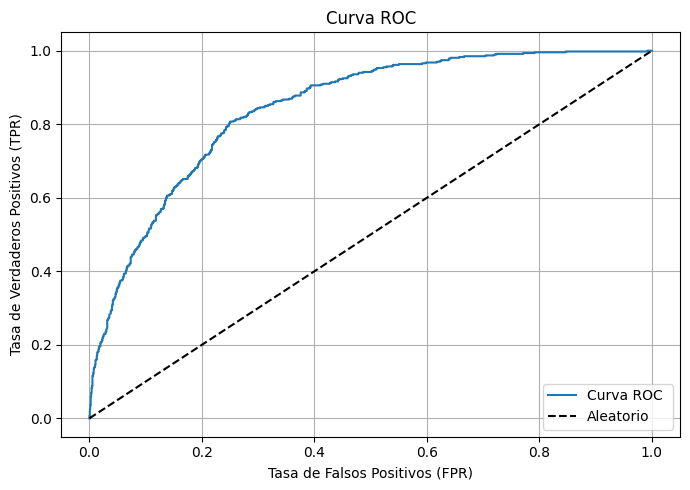

AUC (Área bajo la curva ROC): 0.8441


In [80]:
from sklearn.metrics import roc_curve, roc_auc_score
# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# Calcular AUC
auc_score = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Curva ROC ')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC (Área bajo la curva ROC): {auc_score:.4f}")

Mismo caso para la curva `ROC` y el valor del `AUC`, los cuales no presentaron cambios significativos.

                           feature  importance
45                    TotalCharges    0.162414
44                  MonthlyCharges    0.145517
43                          tenure    0.130000
16               OnlineSecurity_No    0.034138
41  PaymentMethod_Electronic check    0.033103
6                    Dependents_No    0.030345
34         Contract_Month-to-month    0.028966
2                  SeniorCitizen_0    0.027586
10                MultipleLines_No    0.026207
1                      gender_Male    0.025517


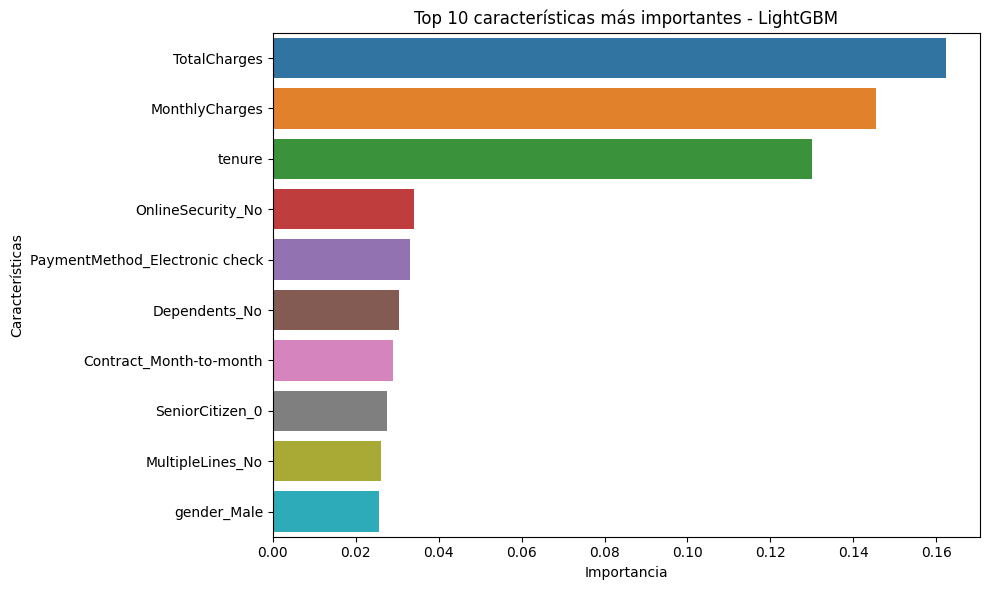

In [81]:
# Extraer el paso del modelo Random Forest
lgbm_model = best_model_lgbm.named_steps["lgbm"]

#Extraer el preprocesador
preprocessor = best_model_lgbm.named_steps["preprocessor"]

# Obtener los nombres de las columnas codificadas con OneHotEncoder
ohe = preprocessor.named_transformers_["cat"]
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)

# Detectamos cuáles columnas no fueron categóricas
num_cols = [c for c in X.columns if c not in cat_cols]

# Concatenamos nombres codificados + numéricos
feature_names = list(encoded_cat_cols) + num_cols

# Obtenemos importancias del modelo
importances = lgbm_model.feature_importances_
importances = importances / importances.sum()  # Normalización de las importances

# Creamos DataFrame con nombres y valores
feat_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Las 10 características más importantes
print(feat_importances.head(10))

# Graficamos las 10 características más importantes
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feat_importances.head(10))
plt.title("Top 10 características más importantes - LightGBM")
plt.xlabel("Importancia")   
plt.ylabel("Características")
plt.tight_layout()
plt.show()


Y para las características más importantes, en este caso las variables **numéricas** (`TotalCharges`, `MonthlyCharges` y `tenure`) fueron las que tuvieron un mejor desempeño a la hora de dividir la variable objetivo.

### 2.5 Conclusiones del entrenamiento

Como se pudo ver a lo largo de este notebook:

- Los modelos **basados en Gradient Boosting** (`XGBoost`, `CatBoost` y `LightGBM`) tuvieron resultados y rendimientos similares: una buena capacidad para clasificar correctamente a gran parte de los registros asociados a la clase negativa, pero una no tan buena para la clase positiva.

- El modelo de `Random Forest` por otro lado, si bien tuvo un rendimiento peor en la clase negativa, la predicción de la clase positiva fue mejor.

- Todos los modelos obtuvieron resultados muy similares en el valor `AUC` que estuvimos considerando para la selección de los mejores parámetros, entre 0.84 y 0.85.

Entonces, como no hay una diferencia tan marcada en el valor `AUC`, decidimos que es más importante la reducción de falsos negativos , es decir, los casos en los que el cliente se marcó como que no abandona la empresa, cuando en realidad si lo hace, lo que podría generar pérdidas en la compañía. Es por esto que para "desempatar" la métrica `roc_auc`, decidimos escoger el modelo que presentó el `recall` más alto para la clase positiva, que en este caso es el modelo `Random Forest`, que estaremos utilizando para la parte del **mlops**.

In [82]:
best_model=best_model_rf

In [88]:
import joblib
joblib.dump(best_model, "C:/ML/projects/telco-churn-mlops/app/telco_churn_model.joblib")

['C:/ML/projects/telco-churn-mlops/app/telco_churn_model.joblib']